<a href="https://colab.research.google.com/github/Alexny1992/airline_flight_delay_prediction/blob/main/Flight_Delay_Prediction_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!pip install pyspark
!pip install prophet


# New Section

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prophet as fbprophet
from pyspark.sql import SparkSession
from pyspark.sql.functions import to_date, concat, col, lit, month, date_format
import os
import requests


In [4]:
file_path = '/content/drive/MyDrive/Data_Analysis/Airline_Delay_Cause.csv'
try:
  df = SparkSession.builder.appName('Airline_Delay_Cause').getOrCreate()
  data = df.read.csv(file_path, header=True, inferSchema=True)
  print("File read successfully")
except Exception as e:
  print(f"Error reading file: {e}")
print(data)

File read successfully
DataFrame[year: int, month: int, carrier: string, carrier_name: string, airport: string, airport_name: string, arr_flights: double, arr_del15: double, carrier_ct: double, weather_ct: double, nas_ct: double, security_ct: double, late_aircraft_ct: double, arr_cancelled: double, arr_diverted: double, arr_delay: double, carrier_delay: double, weather_delay: double, nas_delay: double, security_delay: double, late_aircraft_delay: double]


In [78]:
data.show()

+----+-----+-------+-----------------+-------+--------------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+
|year|month|carrier|     carrier_name|airport|        airport_name|arr_flights|arr_del15|carrier_ct|weather_ct|nas_ct|security_ct|late_aircraft_ct|arr_cancelled|arr_diverted|arr_delay|carrier_delay|weather_delay|nas_delay|security_delay|late_aircraft_delay|
+----+-----+-------+-----------------+-------+--------------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+
|2024|    7|     9E|Endeavor Air Inc.|    ABE|Allentown/Bethleh...|       90.0|     29.0|     12.76|      3.06|   7.9|        0.0|            5.28|          7.0|         0.0|   1815.0|        925.0|        207.0|    321.0|    

In [80]:
data.describe().show()

+-------+------------------+-----------------+-------+--------------------+-------+--------------------+-----------------+------------------+-----------------+-----------------+-----------------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|              year|            month|carrier|        carrier_name|airport|        airport_name|      arr_flights|         arr_del15|       carrier_ct|       weather_ct|           nas_ct|        security_ct|  late_aircraft_ct|     arr_cancelled|      arr_diverted|         arr_delay|     carrier_delay|     weather_delay|         nas_delay|    security_delay|late_aircraft_delay|
+-------+------------------+-----------------+-------+--------------------+-------+--------------------+-----------------+------------------+-----------------+-----------------+-----------------+-------------------+---------

In [18]:
unique_airports = data.select("airport", "airport_name" ).distinct()
print(unique_airports.show())

+-------+--------------------+
|airport|        airport_name|
+-------+--------------------+
|    HVN|New Haven, CT: Tw...|
|    BLV|Belleville, IL: S...|
|    PUW|Pullman, WA: Pull...|
|    LMT|Klamath Falls, OR...|
|    LWS|Lewiston, ID: Lew...|
|    TVC|Traverse City, MI...|
|    DRO|Durango, CO: Dura...|
|    IND|Indianapolis, IN:...|
|    HYA|Hyannis, MA: Cape...|
|    FCA|Kalispell, MT: Gl...|
|    ACK|Nantucket, MA: Na...|
|    SEA|Seattle, WA: Seat...|
|    TUL|Tulsa, OK: Tulsa ...|
|    HRL|Harlingen/San Ben...|
|    CPR|Casper, WY: Caspe...|
|    PBG|Plattsburgh, NY: ...|
|    HIB|Hibbing, MN: Rang...|
|    ISN|Williston, ND: Sl...|
|    GPT|Gulfport/Biloxi, ...|
|    SAF|Santa Fe, NM: San...|
+-------+--------------------+
only showing top 20 rows

None


In [35]:
unique_airports = data.select("carrier_name" ).distinct()
print(unique_airports.show(51,truncate=False))


+-----------------------------------------+
|carrier_name                             |
+-----------------------------------------+
|GoJet Airlines LLC d/b/a United Express  |
|Hawaiian Airlines Network                |
|Alaska Airlines Network                  |
|Endeavor Air Inc.                        |
|CommuteAir LLC dba CommuteAir            |
|Allegiant Air                            |
|Delta Air Lines Network                  |
|American Eagle Airlines Inc.             |
|SkyWest Airlines Inc.                    |
|Virgin America                           |
|PSA Airlines Inc.                        |
|Horizon Air                              |
|United Air Lines Inc.                    |
|American Airlines Network                |
|Piedmont Airlines                        |
|Air Wisconsin Airlines Corp              |
|Trans States Airlines                    |
|Compass Airlines                         |
|Republic Airline                         |
|Peninsula Airways Inc.         

In [67]:
carrier_name = 'JetBlue Airways'
airport_code = 'JFK'
df_filtered = data.filter((data['carrier_name'] == carrier_name) & (data['airport'] == airport_code))
print(df_filtered.show())

+----+-----+-------+---------------+-------+--------------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+
|year|month|carrier|   carrier_name|airport|        airport_name|arr_flights|arr_del15|carrier_ct|weather_ct|nas_ct|security_ct|late_aircraft_ct|arr_cancelled|arr_diverted|arr_delay|carrier_delay|weather_delay|nas_delay|security_delay|late_aircraft_delay|
+----+-----+-------+---------------+-------+--------------------+-----------+---------+----------+----------+------+-----------+----------------+-------------+------------+---------+-------------+-------------+---------+--------------+-------------------+
|2024|    7|     B6|JetBlue Airways|    JFK|New York, NY: Joh...|     3198.0|   1016.0|    305.78|     18.31|285.38|       0.08|          406.46|         73.0|        17.0|  94990.0|      35325.0|       1522.0|  19613.0|           5

In [68]:
df = df_filtered.withColumn('ds', to_date(concat(col('year'),lit('-'),col('month'))))

In [74]:
df_filtered = df.withColumn('flight_ratio', col('arr_del15')/col('arr_flights')*100)
df_filtered = df_filtered.select('ds', 'flight_ratio')
df_filtered.show()

+----------+------------------+
|        ds|      flight_ratio|
+----------+------------------+
|2024-07-01|31.769856160100062|
|2024-06-01|29.602070527337432|
|2024-05-01|25.070510811657787|
|2024-04-01| 21.47039687703318|
|2024-03-01| 31.43976493633692|
|2024-02-01| 24.67289719626168|
|2024-01-01| 27.76951672862453|
|2023-12-01|              31.0|
|2023-11-01|24.107415318889228|
|2023-10-01| 28.50705917693001|
|2023-09-01| 39.17621554660886|
|2023-08-01| 35.28563185227929|
|2023-07-01|46.136233543216946|
|2023-06-01|36.947904869762176|
|2023-05-01| 25.68527918781726|
|2023-04-01| 34.27587902630932|
|2023-03-01|31.655992680695334|
|2023-02-01|24.634146341463413|
|2023-01-01|27.089864158829673|
|2022-12-01| 40.97523615011489|
+----------+------------------+
only showing top 20 rows



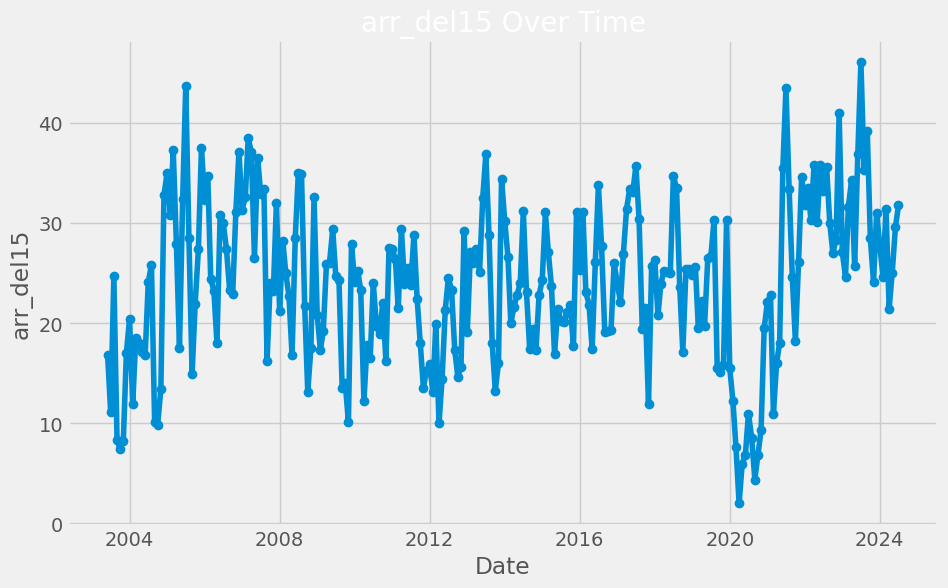

In [75]:
pandas_df = df_filtered.select('ds', 'flight_ratio').toPandas()
pandas_df = pandas_df.sort_values(by='ds')

plt.figure(figsize=(10, 6))
plt.style.use('fivethirtyeight')
plt.plot(pandas_df['ds'], pandas_df['flight_ratio'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('arr_del15')
plt.title('arr_del15 Over Time')
plt.show()

# Cross Validation
